## Importing packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from math import pi
from GPclass import GaussianProcess
from scipy.stats import norm

## Sinus test

0.15865525393145707 0.24197072451914337


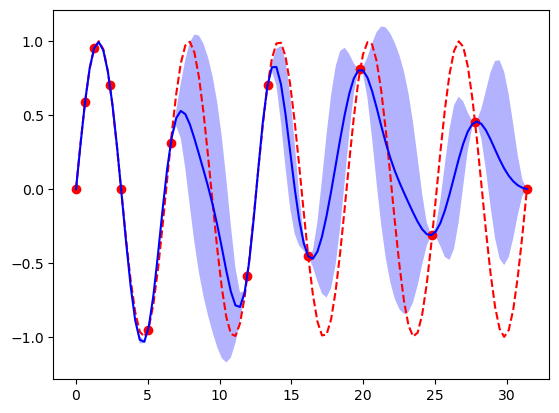

In [378]:
X_train = np.array([0.0, 0.2, 0.4, 0.75, 1, 1.6, 2.1, 3.8, 4.25, 5.15, 6.3, 7.9, 8.85, 10.0], ndmin=2).T*pi
y_train = np.sin(X_train)# + 0.05*np.random.normal(size = X_train.shape)

X_test = np.linspace(0,10*pi,100).reshape(-1,1)
y_test = np.sin(X_test)# + 0.05*np.random.normal(size = X_test.shape)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

X_ex = np.array([0.41*pi], ndmin=2)
mu_sample = GP.predict(X_train)
mu, sigma = GP.predict(X_ex)
mu_sample_opt = np.max(GP.predict(X_train))
mu2, sigma2 = GP.predict(X_test)


xi = 0.001

imp = mu - mu_sample_opt - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) +  sigma * norm.pdf(Z)
print(norm.cdf(-1),norm.pdf(-1))
upper95 = mu2 + 1.96*sigma2
lower95 = mu2 - 1.96*sigma2
# Plotting
plt.plot(X_test,y_test, 'r--')
plt.plot(X_train,y_train,'ro')
plt.plot(X_test,mu2, 'b')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b')

In [ ]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.plot(X_train,y_train,'ro')
plt.plot(X_test,y_test, 'k')
plt.plot(X_test,y_pred, 'r--')
plt.plot(X_test,upper95, 'b--')
plt.plot(X_test,lower95, 'b--')

In [290]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, gpr_h, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr, gpr_h)
    
#     print(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)))
    
    # Find the best optimum by starting from n_restart different random points.
    
    for x0 in np.random.uniform(bounds[:, 0], bounds[:,1],size=(n_restarts, dim)):
        
        #print(len(x0))
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [291]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, gpr_h, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
        **kwargs: GPR for modelling the hidden constraint values (arg name : 'gpr_h')
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    #Computing the posterior mean and var for the hidden constraint
    mu_h, sigma_h = gpr_h.predict(X, return_std=True)

    sigma_h = sigma_h.reshape(-1, 1)


    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
             
        #Compting new acquisition function
        ei = ei * norm.cdf(-mu_h/sigma_h)

        
    return ei

In [391]:
X_train = np.array([0.0, 0.2, 0.5, 0.75, 1, 1.6, 2.1, 3.8, 4.25, 5.15, 6.3, 7.9, 8.85, 10.0], ndmin=2).T*pi
y_train = np.sin(X_train)

X_test = np.linspace(0,10*pi,100).reshape(-1,1)
y_test = np.sin(X_test)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

6 % 5

1

## Sinus test going through point by point, without optimizing next step

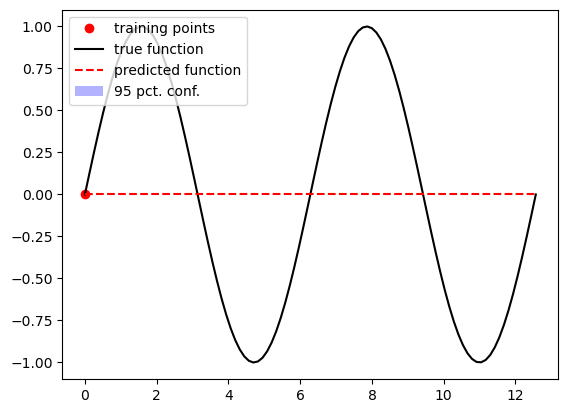

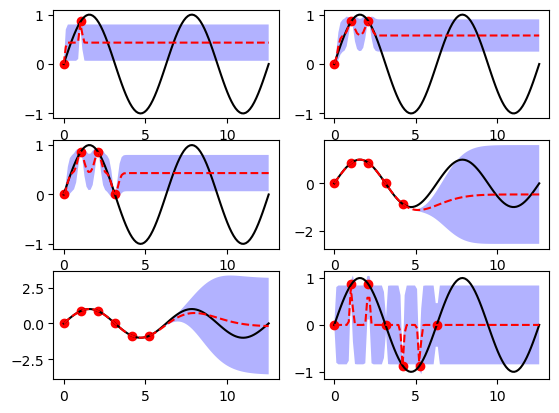

In [435]:
X_train = np.array([0.0], ndmin=2).T
y_train = np.sin(X_train)

GP = GaussianProcess(n_restarts=1, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
#print(GP.mu, GP.SigmaSqr)

X_test = np.linspace(0,4*pi,100).reshape(-1,1)
y_test = np.sin(X_test)# + 0.05*np.random.normal(size = X_test.shape)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="upper left")

k = 6
fig1, axs1 = plt.subplots(3, 2)
X_list = np.linspace(0,2*pi,k+1)
y_list = np.sin(X_list)
for i in range(k):
    if i < 2:
        m = 0
        l = i
    else:
        if i < 4:
            m = 1
            l = i -2
        else:
            m = 2
            l = i - 4
    X_train = np.append(X_train, X_list[i+1]).reshape(-1,1)
    y_train = np.sin(X_train)
    GP = GaussianProcess(n_restarts=1, optimizer='L-BFGS-B')
    GP.fit(X_train, y_train)
    y_pred, y_pred_SSqr = GP.predict(X_test)
    upper95 = y_pred + 1.96*y_pred_SSqr
    lower95 = y_pred - 1.96*y_pred_SSqr
    axs1[m,l].plot(X_train,y_train,'ro')
    axs1[m,l].plot(X_test,y_test, 'k')
    axs1[m,l].plot(X_test,y_pred, 'r--')
    axs1[m,l].fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b')


## Step-by-step sinus test with optimized step

samples prior [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
min_val -2.079441541679836 min_x [2.]
min_val -2.8261379756443357 min_x [2.]
0 0
min_val -15.50990031621656 min_x [2.]
0 1
min_val -28.463837851288837 min_x [4.66666667]
1 0
min_val -26.06853102928638 min_x [-0.44415306]
1 1


/Users/kofoed/Documents/repos/lambo_kofoed/Simple1D_example/GPclass.py:54: RuntimeWarning: overflow encountered in power
  theta = 10**theta    # Correlation length
/Users/kofoed/Documents/repos/lambo_kofoed/Simple1D_example/GPclass.py:39: RuntimeWarning: invalid value encountered in multiply
  K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
/Users/kofoed/opt/anaconda3/envs/lambo-env/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


min_val -28.838751229870986 min_x [-0.78444876]
2 0
min_val -33.60831653050207 min_x [-0.83625877]
2 1


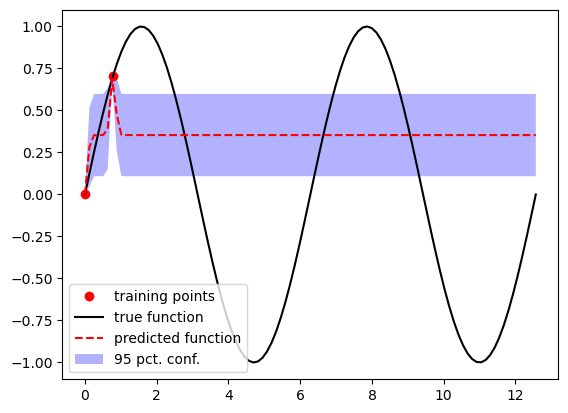

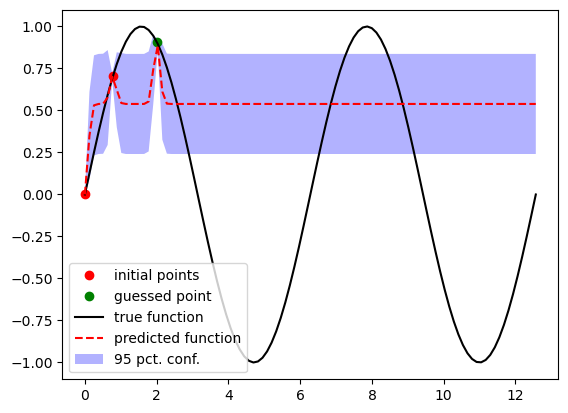

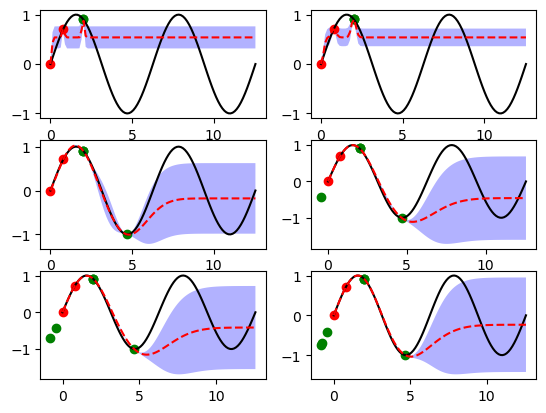

In [466]:
X_train = np.array([0.0, 0.25*pi], ndmin=2).T
y_train = np.sin(X_train)
num_samples = 10

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
#print(GP.mu, GP.SigmaSqr)

X_test = np.linspace(0,4*pi,100).reshape(-1,1)
y_test = np.sin(X_test)# + 0.05*np.random.normal(size = X_test.shape)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.figure()
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

samples = np.linspace(0,1,num_samples)
print("samples prior", samples)
    # We know the underlying function is a sinus function
    # This means we have bounds -1 to 1
    # We scale our samples to match the bounds
ub, lb = -1, 1
samples = np.expand_dims((ub-lb)*samples + lb,axis=1)

min_val = 1
for i in range(num_samples):
    res = minimize(GP.Neglikelihood,samples[i,:], method=GP.optimizer)
    if res.fun < min_val:
            min_val = res.fun
            min_x = res.x   

print("min_val", min_val, "min_x", min_x)
X_train = np.append(X_train,min_x).reshape(-1,1)
y_train = np.sin(X_train)

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.figure()
plt.plot(X_train[0:2,:],y_train[0:2,:],'ro', label='initial points')
plt.plot(X_train[2:,:],y_train[2:,:],'go', label='guessed point')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

figs, axs = plt.subplots(3,2)
m = 0
l = 0
for j in range(6):
    min_val = 1
    for i in range(num_samples):
        res = minimize(GP.Neglikelihood,samples[i,:], method=GP.optimizer)
        if res.fun < min_val:
                min_val = res.fun
                min_x = res.x 
    
    print("min_val", min_val, "min_x", min_x)
    X_train = np.append(X_train,min_x).reshape(-1,1)
    y_train = np.sin(X_train)

    GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
    GP.fit(X_train, y_train)
    y_pred, y_pred_SSqr = GP.predict(X_test)
    upper95 = y_pred + 1.96*y_pred_SSqr
    lower95 = y_pred - 1.96*y_pred_SSqr

    if j < 2:
        m = 0
        l = j
    else:
        if j < 4:
            m = 1
            l = j -2
        else:
            m = 2
            l = j - 4
    print(m,l)
    axs[m,l].plot(X_train[0:2,:],y_train[0:2,:],'ro', label='initial points')
    axs[m,l].plot(X_train[2:,:],y_train[2:,:],'go', label='guessed point')
    axs[m,l].plot(X_test,y_test, 'k', label='true function')
    axs[m,l].plot(X_test,y_pred, 'r--', label='predicted function')
    axs[m,l].fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')

## Sinus and quadratic 1D test 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


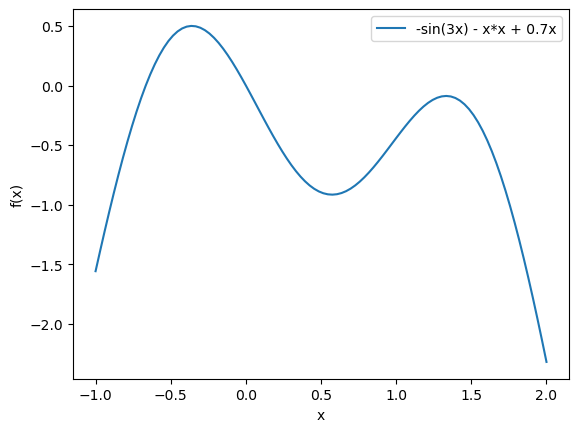

In [83]:
def test_fun(X):
    return -np.sin(3*X) - X**2 + 0.7*X 

X_test = np.linspace(-1,2,100).reshape(-1,1)
y_test = test_fun(X_test)
plt.plot(X_test,y_test, label='-sin(3x) - x*x + 0.7x')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("test_fun.eps")

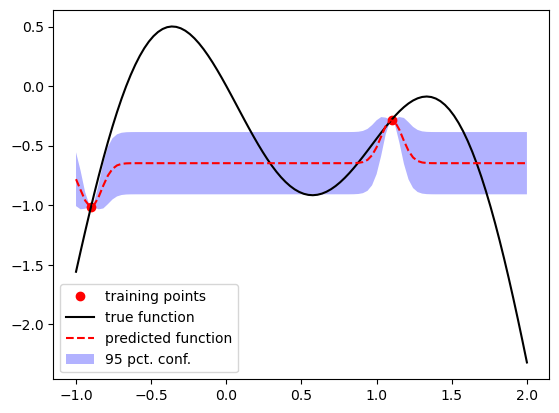

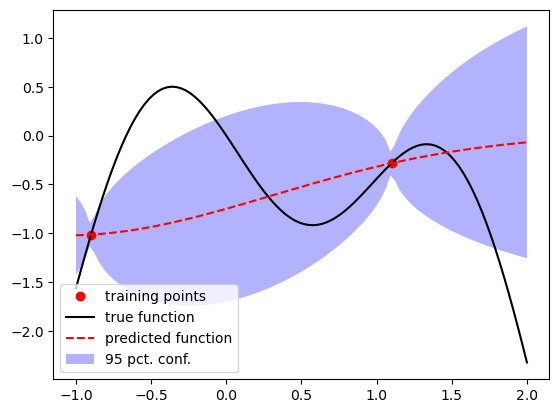

In [623]:
noise = 0
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
X_train = np.array([-0.9, 1.1], ndmin=2).T
y_train = test_fun(X_train)
num_samples = 10

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
gpr.fit(X_train, y_train)
y_pred2, y_pred_SSqr2 = gpr.predict(X_test, return_std=True)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
upper952 = y_pred2 + 1.96*np.sqrt(y_pred_SSqr2)
lower952 = y_pred2 - 1.96*np.sqrt(y_pred_SSqr2)
plt.figure()
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")
plt.figure()
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred2, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower952, upper952, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

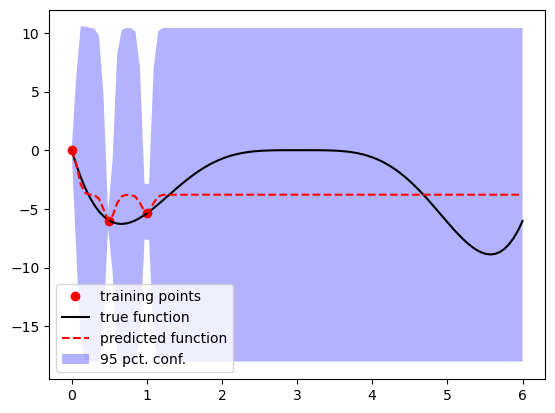

In [564]:
X_train = np.array([0.0, 0.5, 1.], ndmin=2).T
y_train = test_fun(X_train)
num_samples = 10

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
#print(GP.mu, GP.SigmaSqr)

X_test = np.linspace(0,6,100).reshape(-1,1)
y_test = test_fun(X_test)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.figure()
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

#### Functions

In [581]:
def best_new_point(acquisition_function, X_train, y_train, gp, bounds, n_restarts):
    m = X_train.shape[1]
    min_val = 1000
    min_x = None
    

    def min_obj(X):
        return -acquisition_function(X.reshape(-1, m), X_train, y_train, gp)

    for x0 in np.random.uniform(bounds[0], bounds[1], size=(n_restarts, m)):
        res = minimize(min_obj, x0=x0, bounds=Bounds(bounds[0],bounds[1]), method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    return min_x.reshape(-1,1)

In [604]:
def EHVI(X, X_train, y_train, gp, tau=0.1):
    mu, sigmaSqr = gp.predict(X)
    sigma = np.sqrt(sigmaSqr)
    m_opt = np.max(y_train)

    improvement = mu - m_opt - tau
    Z = improvement / sigma
    ehvi = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ehvi[sigma == 0] = 0.0

    return ehvi



#### Continue

In [609]:
X_train = np.array([0.0, 0.5, 1.4], ndmin=2).T
y_train = test_fun(X_train)
bounds = [0,6]
num_samples = 10

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
x_new = best_new_point(EHVI, X_train, y_train, GP, bounds, GP.n_restarts)
print(x_new)

[[4.88802617]]


In [ ]:
X_train = np.array([0.0, 0.25*pi], ndmin=2).T
y_train = np.sin(X_train)
num_samples = 10

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
#print(GP.mu, GP.SigmaSqr)

X_test = np.linspace(0,4*pi,100).reshape(-1,1)
y_test = np.sin(X_test)# + 0.05*np.random.normal(size = X_test.shape)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.figure()
plt.plot(X_train,y_train,'ro', label='training points')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

samples = np.linspace(0,1,num_samples)
ub, lb = 6, 0
samples = np.expand_dims((ub-lb)*samples + lb,axis=1)

min_val = 1
for i in range(num_samples):
    res = minimize(GP.Neglikelihood,samples[i,:], method=GP.optimizer)
    if res.fun < min_val:
            min_val = res.fun
            min_x = res.x   

print("min_val", min_val, "min_x", min_x)
X_train = np.append(X_train,min_x).reshape(-1,1)
y_train = np.sin(X_train)

GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr
plt.figure()
plt.plot(X_train[0:2,:],y_train[0:2,:],'ro', label='initial points')
plt.plot(X_train[2:,:],y_train[2:,:],'go', label='guessed point')
plt.plot(X_test,y_test, 'k', label='true function')
plt.plot(X_test,y_pred, 'r--', label='predicted function')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')
plt.legend(loc="lower left")

figs, axs = plt.subplots(3,2)
m = 0
l = 0
for j in range(6):
    min_val = 1
    for i in range(num_samples):
        res = minimize(GP.Neglikelihood,samples[i,:], method=GP.optimizer)
        if res.fun < min_val:
                min_val = res.fun
                min_x = res.x 
    
    print("min_val", min_val, "min_x", min_x)
    X_train = np.append(X_train,min_x).reshape(-1,1)
    y_train = np.sin(X_train)

    GP = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
    GP.fit(X_train, y_train)
    y_pred, y_pred_SSqr = GP.predict(X_test)
    upper95 = y_pred + 1.96*y_pred_SSqr
    lower95 = y_pred - 1.96*y_pred_SSqr

    if j < 2:
        m = 0
        l = j
    else:
        if j < 4:
            m = 1
            l = j -2
        else:
            m = 2
            l = j - 4
    print(m,l)
    axs[m,l].plot(X_train[0:2,:],y_train[0:2,:],'ro', label='initial points')
    axs[m,l].plot(X_train[2:,:],y_train[2:,:],'go', label='guessed point')
    axs[m,l].plot(X_test,y_test, 'k', label='true function')
    axs[m,l].plot(X_test,y_pred, 'r--', label='predicted function')
    axs[m,l].fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b', label='95 pct. conf.')

# Best example

## Initial case (No constraints)

### Initialization

In [98]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.1

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape) + 2

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

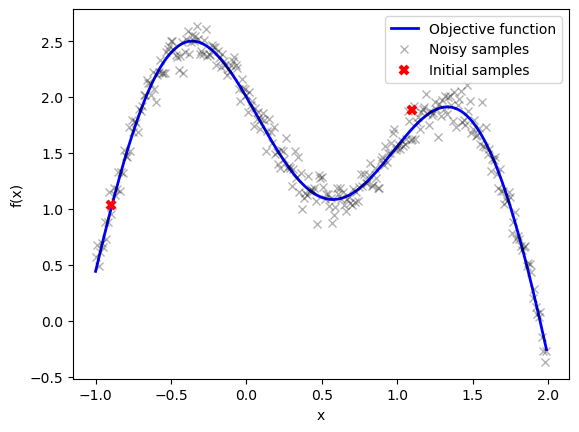

In [99]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'b', lw=2, label='Objective function')
plt.plot(X, f(X), 'kx', lw=1, alpha=0.3, label='Noisy samples')
plt.plot(X_init, Y_init, 'rx', mew=3, label='Initial samples')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("test_fun.pdf")

### Functions

In [54]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = (mu - mu_sample_opt - xi).reshape(-1,1)
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [55]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [86]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.2, color='y') 
    plt.plot(X, Y, 'b-', lw=2, label='Noise-free objective')
    plt.plot(X, mu, 'y--', lw=2, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    plt.plot(-0.359394,2.50036, 'ro', mew=2, alpha=0.8, mfc='none', label='Optimal point')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()  

### Bayesian Optimization

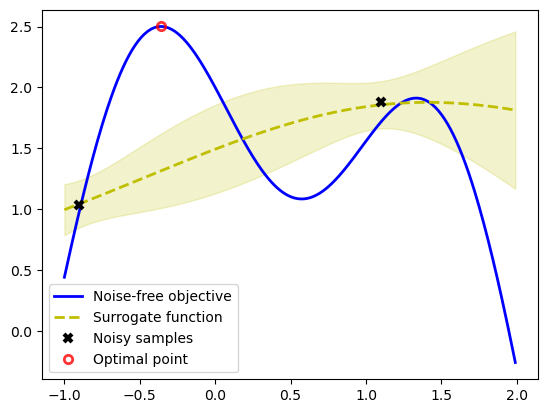

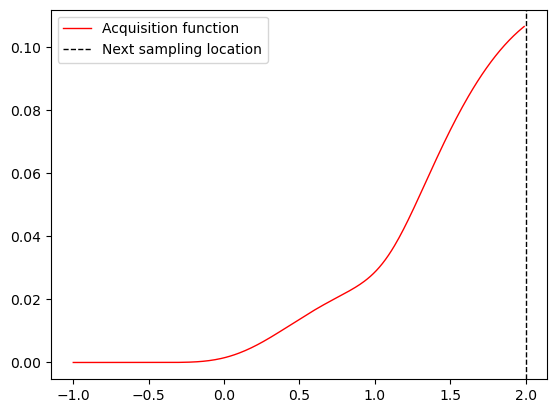

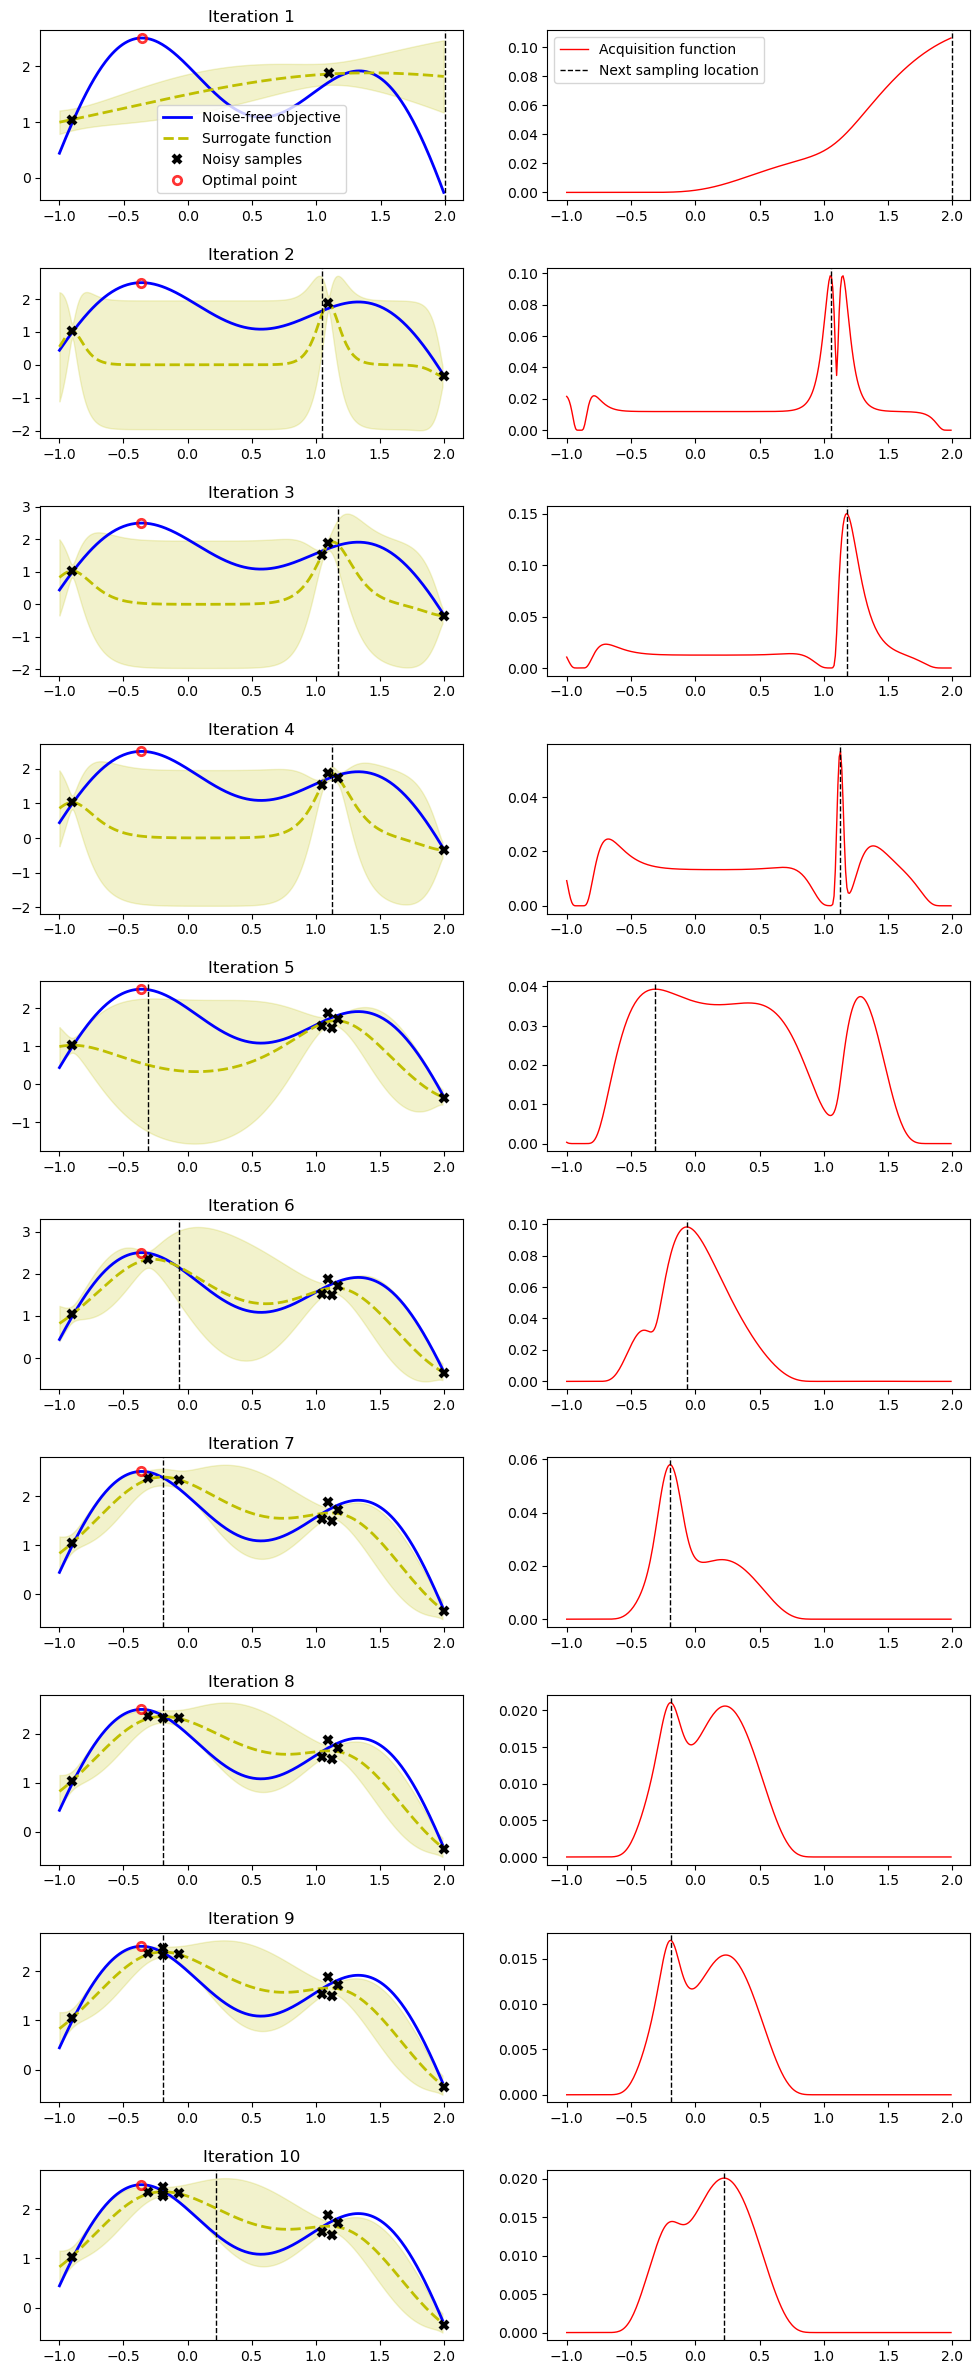

In [102]:
# Gaussian process with Matérn kernel as surrogate model
m52 = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
xi = 0.01

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10


for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    if i==0:
        plt.figure()
        plot_approximation(gpr, X, Y, X_sample, Y_sample, show_legend=i==0)
        plt.savefig("init_pred.pdf")
        plt.figure()
        plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
        plt.savefig("init_acq.pdf")
        plt.figure(figsize=(12, n_iter * 3))
        plt.subplots_adjust(hspace=0.4)
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
plt.savefig("bo_toy.pdf")

## Now with constraint

### Initialization

In [189]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.1

def f_h(X, noise=0.0):
    return X**2 - 3*np.sin(X) + noise * np.random.randn(*X.shape)

def f_hb(X, noise=0.0):
    output = 1*(f_h(X, noise) < 0.5)
    return output.ravel()

def f(X, noise=0.0):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape) + 2

# Initial samples
X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init,noise)
H_init = f_h(X_init,noise)
HB_init = f_hb(X_init,noise)

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free hidden function values at X 
H = f_h(X,0)
Hb = f_hb(X,0)
# Noisy hidden function values at X
Hn = f_h(X,noise=noise)
HBn = f_hb(X,noise=noise)
# Noise-free objective function values at X 
Y = f(X,0)
# Noisy objective function values at X
Yn = f(X,noise=noise)


### Functions

In [193]:
from symbol import return_stmt


def I_expected_improvement(X, X_sample, gpr, gpr_h, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    mu_h = gpr_h.predictproba(X)[1]
    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)
    with np.errstate(divide='warn'):
        imp = (mu - mu_sample_opt - xi).reshape(-1,1)
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei*mu_h

In [154]:
def I_propose_location(acquisition, X_sample, gpr, gpr_h, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, gpr, gpr_h)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
            
    return min_x.reshape(-1, 1)

In [267]:
def plot_i_approximation(gpr, X, Y, X_sample, Y_sample, gpr_h, Hb, H_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    mu_h = gpr_h.predict_proba(X)[:,1]
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1, color='y')
    plt.plot(X, Y, 'b-', lw=1, label='Noise-free objective')
    plt.plot(X, Hb, 'g-', lw=1, label='Noise-free hidden objective')
    plt.plot(X, mu, 'y--', lw=1, label='Surrogate objective function')
    plt.plot(X, mu_h, 'm-', lw=1, label='Surrogate constraint function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        # plt.xlim(right=np.max(X)+6)
        plt.legend()

def plot_i_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    plt.axvspan(-0.158917,1.84142, color='green',alpha=0.3, label='Noise-free allowed area')
    if show_legend:
        # plt.xlim(right=np.max(X)+6)
        plt.legend()

### Plotting

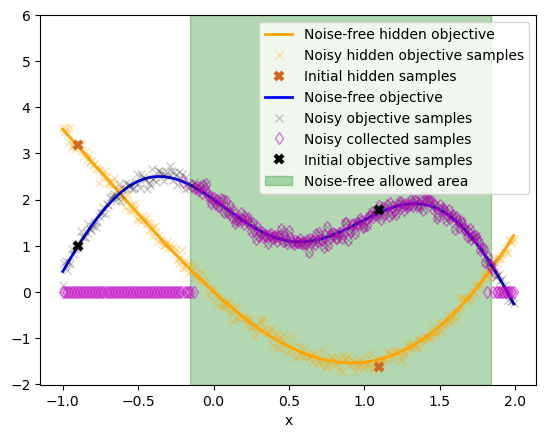

In [246]:
# Plot optimization objective with noise level 
plt.plot(X, H, color='orange', lw=2, label='Noise-free hidden objective')
plt.plot(X, Hn, color='orange', marker='x', ls='', alpha=0.3, label='Noisy hidden objective samples')
plt.plot(X_init, H_init, color='chocolate', marker='x', ls='', mew=3, label='Initial hidden samples')
plt.plot(X, Y, 'b-', lw=2, label='Noise-free objective')
plt.plot(X, Yn, 'kx', mew=1, alpha=0.2, label='Noisy objective samples')
plt.plot(X, Yn.ravel()*HBn, 'md', mew=1, alpha=0.5, mfc='none', label='Noisy collected samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial objective samples')
plt.axvspan(-0.158917,1.84142, color='green',alpha=0.3, label='Noise-free allowed area')
plt.ylim(top=6)
plt.xlabel("x")
plt.legend()
plt.savefig("const_init.pdf")

### Full process

In [178]:

m52_h = Matern(length_scale=1.0, nu=2.5)
gpr_h = GaussianProcessClassifier(kernel=m52_h)
gpr = GaussianProcessRegressor(kernel=m52_h, alpha=noise**2)
# Initialize samples
X_sample = X_init
Y_sample = Y_init
H_sample = HB_init
# gpr.fit(X_sample, Y_sample)
gpr_h.fit(X_sample, H_sample)
print(Y_sample.shape,(H_sample.ravel()).shape)

(2, 1) (2,)


/Users/kofoed/opt/anaconda3/envs/lambo-env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


<Figure size 1200x1500 with 0 Axes>

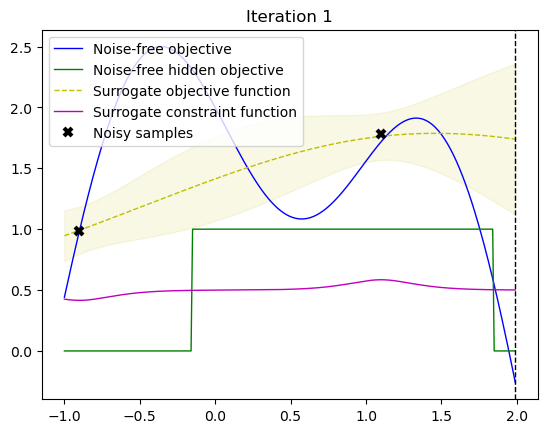

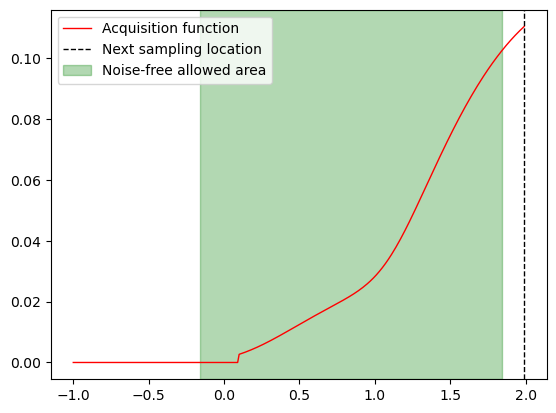

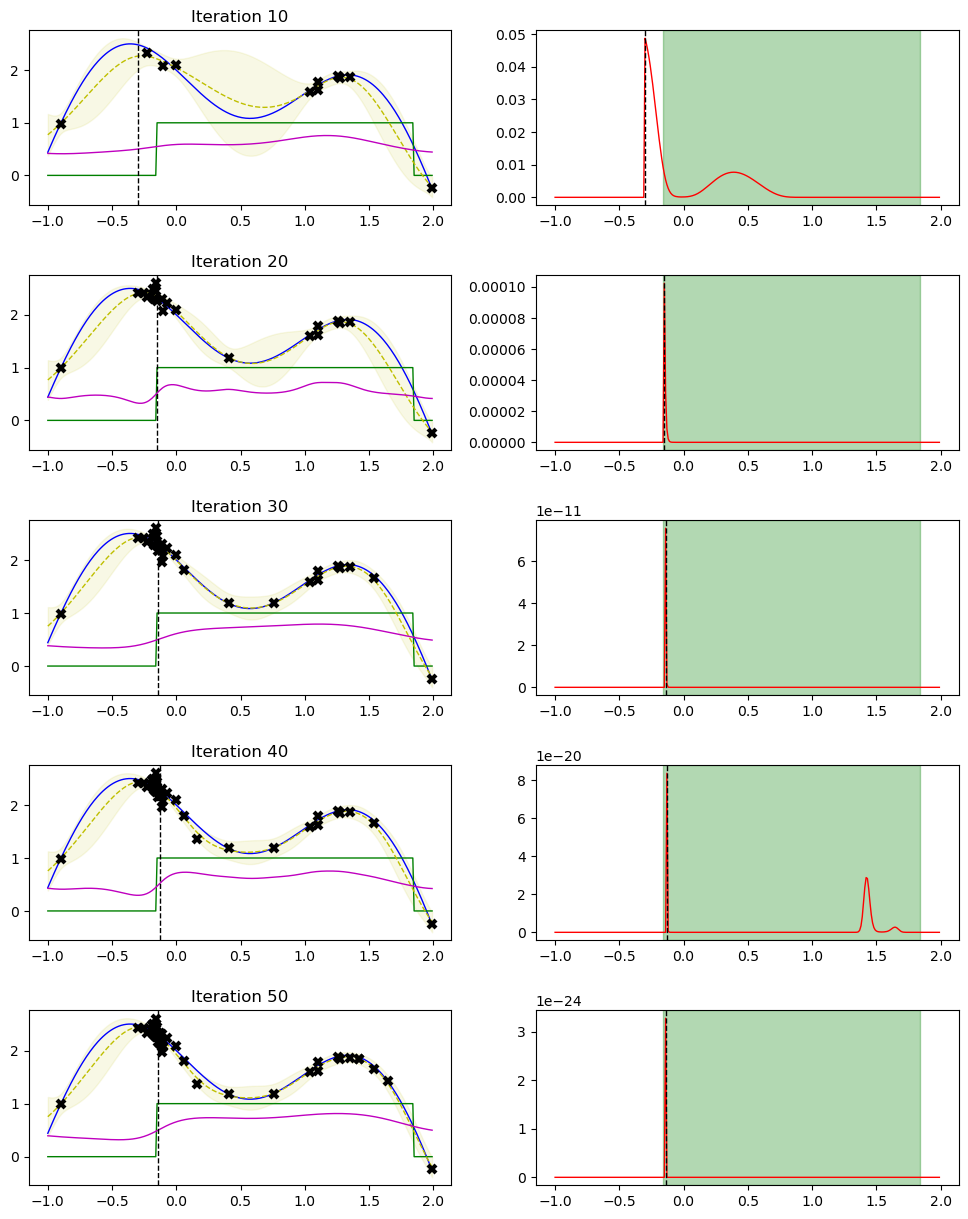

In [270]:
# Gaussian process with Matérn kernel as surrogate model
m52 = Matern(length_scale=1.0, nu=2.5)
m52_h = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
gpr_h = GaussianProcessClassifier(kernel=m52_h)
xi = 0.00

# Initialize samples
X_sample = X_init
Y_sample = Y_init
H_sample = HB_init

# Number of iterations
n_iter = 50
n_fig = int(n_iter/10)
plt.figure(figsize=(12, n_fig * 3))
plt.subplots_adjust(hspace=0.4)
for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    gpr_h.fit(X_sample, H_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    Y_test = I_expected_improvement(X, X_sample=X_sample, gpr=gpr, gpr_h=gpr_h)
    X_next = X[np.argmax(Y_test)]
    # X_next = I_propose_location(I_expected_improvement, X_sample, gpr, gpr_h, bounds)
    
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    H_next = f_hb(X_next, noise)

    if i == 0:
        # Plot samples, surrogate function, noise-free objective and next sampling location
        plt.figure()
        plot_i_approximation(gpr, X, Y, X_sample, Y_sample, gpr_h, Hb, H_sample, X_next, show_legend=i==0)
        plt.title(f'Iteration {i+1}')
        plt.savefig("it1const.pdf")
        plt.figure()
        plot_i_acquisition(X, I_expected_improvement(X, X_sample, gpr, gpr_h), X_next, show_legend=i==0)
        plt.savefig("it1constacq.pdf")
        plt.figure(figsize=(12, n_fig * 3))
        plt.subplots_adjust(hspace=0.4)
    
    if (i+1) % 10 == 0:
        j = int((i+1)/10)-1
        # Plot samples, surrogate function, noise-free objective and next sampling location
        plt.subplot(n_fig, 2, 2 * j + 1)
        plot_i_approximation(gpr, X, Y, X_sample, Y_sample, gpr_h, Hb, H_sample, X_next, show_legend=i==0)
        plt.title(f'Iteration {i+1}')
        plt.subplot(n_fig, 2, 2 * j + 2)
        plot_i_acquisition(X, I_expected_improvement(X, X_sample, gpr, gpr_h), X_next, show_legend=i==0)
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    H_sample = np.hstack((H_sample, H_next))
plt.savefig("constrained_toy.pdf")

## Probabilistic constraint

### Initialization

In [91]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f_h(X, noise=0.0):
    return X**2 - 3*np.sin(X)

def f_hb(X, noise=0.0):
    output = f_h(X, noise) < 0.5
    return output

def f(X, noise=0.0):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape) + 2

X_init = np.array([[-0.9],[1.1]])
Y_init = f(X_init, noise=noise)
H_init = f_hb(X_init)

### Functions

In [89]:
def PI_expected_improvement(X, X_sample, Y_sample, H_sample, gpr, gpr_h, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)
    mu_h, sigma_h = gpr_h.predict(X, return_std=True)

    sigma = sigma.reshape(-1, 1)
    mu_h = mu_h.reshape(-1,1)
    mu_h[mu_h > 1] = 1
    mu_h[mu_h < 0] = 0
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = (mu - mu_sample_opt - xi).reshape(-1,1)
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei*mu_h

In [63]:
def PI_propose_location(acquisition, X_sample, Y_sample, H_sample, gpr, gpr_h, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, H_sample, gpr, gpr_h)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    return min_x.reshape(-1, 1)

In [249]:
def plot_i_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    plt.axvspan(-0.158917,1.84142, color='green',alpha=0.3, label='Noise-free allowed area')
    if show_legend:
        plt.legend()

### Plotting

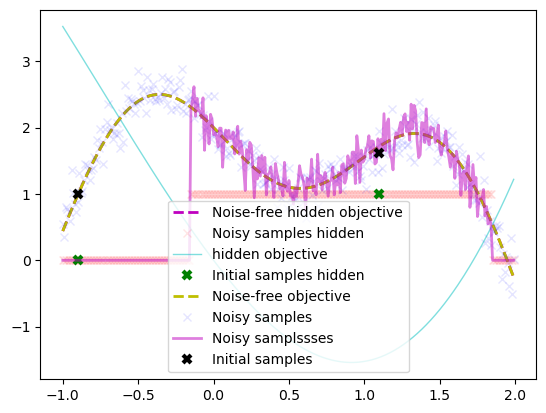

In [21]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
H = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, H, 'm--', lw=2, label='Noise-free hidden objective')
plt.plot(X, f_hb(X), 'rx', lw=1, alpha=0.1, label='Noisy samples hidden')
plt.plot(X, f_h(X), 'c', lw=1, alpha=0.5, label='hidden objective')
plt.plot(X_init, H_init, 'gx', mew=3, label='Initial samples hidden')
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X, f(X)*f_hb(X), 'm', lw=2, alpha=0.5, label='Noisy samplssses')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend()

### Full process

In [250]:
# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
gpr_h = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
xi = 0.01

# Initialize samples
X_sample = X_init
Y_sample = Y_init
H_sample = H_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)
for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    
    gpr_h.fit(X_sample, H_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = PI_propose_location(PI_expected_improvement, X_sample, Y_sample, H_sample, gpr, gpr_h, bounds)
    
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    H_next = f_hb(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')
    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_i_acquisition(X, PI_expected_improvement(X, X_sample, Y_sample, H_sample, gpr, gpr_h), X_next, show_legend=i==0)
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    H_sample = np.vstack((H_sample, H_next))

NameError: name 'PI_propose_location' is not defined

<Figure size 1200x3000 with 0 Axes>

## Himmelblau example test

#### Himmelblau function

In [475]:
def himmelblau(X,Y):
    return (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

[  0.         181.61650537]


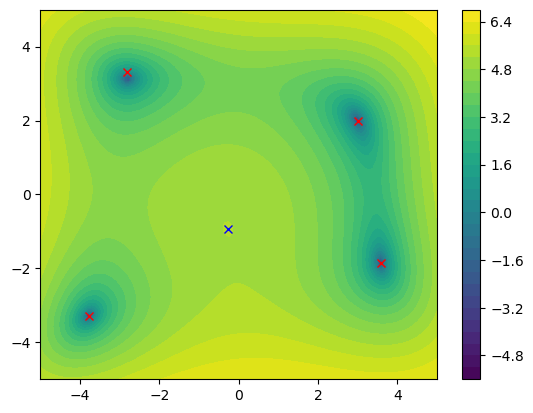

In [508]:
# Global min and max
print(himmelblau(np.array([3.0,-0.27]),np.array([2,-0.923])))

# Grid
xlist = np.linspace(-5.0, 5.0, 100)
ylist = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.log(himmelblau(X,Y))
#Z = himmelblau(X,Y)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, 30)
plt.colorbar(cp)
ax.plot([3,-2.805,-3.779,3.584],[2,3.313,-3.283,-1.848], 'rx')
ax.plot([-0.27],[-0.923], 'bx')
plt.show()

#### Starting gaussian process

## Test from website

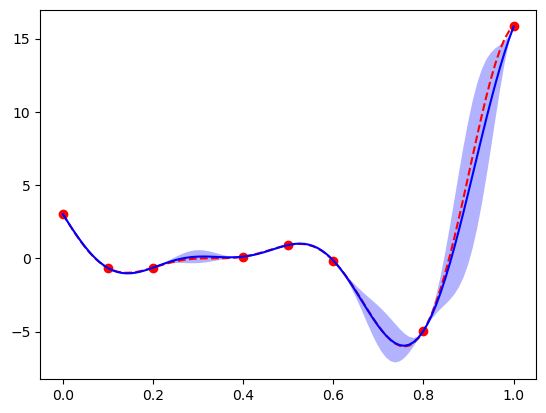

In [523]:
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1], ndmin=2).T

y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)
upper95 = y_pred + 1.96*y_pred_SSqr
lower95 = y_pred - 1.96*y_pred_SSqr

# Plotting
plt.plot(X_test,y_test, 'r--')
plt.plot(X_train,y_train,'ro')
plt.plot(X_test,y_pred, 'b')
plt.fill_between(np.squeeze(X_test),lower95, upper95, alpha=0.3, facecolor='b')

## Working through each step of simple example

In [274]:
def Neglikelihood(X, y, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = Corr(X, X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (y-mu*one).T @ inv_K @ (y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        return -LnLike.flatten()

In [285]:
def Corr(X1, X2, theta):
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K

In [289]:
# Input data
X_simple = np.array([0,pi/2,3*pi/4,3*pi/2, 3, 5 ], ndmin=2).T
y_simple = np.sin(X_simple)
num_samples = 1
theta = np.array([0.5])
optimizer = 'L-BFGS-B'

GP_simple = GaussianProcess(n_restarts=num_samples, optimizer='L-BFGS-B')
GP_simple.X = X_simple
GP_simple.y = y_simple

# should be taken randomly from distribution
# samples = lhs(X_simple.shape[1], samples=num_samples)

# We just take equidistant points between 0 and 1
samples = np.linspace(0,1,num_samples)
print("samples prior", samples)
# We know the underlying function is a sinus function
# This means we have bounds -1 to 1
# We scale our samples to match the bounds
ub, lb = 1, -1
samples = np.expand_dims((ub-lb)*samples + lb,axis=1)
print("scaled samples", samples)

opt_para = np.zeros((GP_simple.n_restarts, GP_simple.X.shape[1]))
opt_func = np.zeros((GP_simple.n_restarts, 1))
for i in range(num_samples):
    res = minimize(GP_simple.Neglikelihood,samples[i,:], method='L-BFGS-B',
        bounds=Bounds(lb*np.ones(X_simple.shape[1]),ub*np.ones(X_simple.shape[1])))
    opt_para[i,:] = res.x
    opt_func[i,:] = res.fun

print("optimal parameters", opt_para)
print("optimal function value", opt_func)



samples prior [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
scaled samples [[-1.        ]
 [-0.77777778]
 [-0.55555556]
 [-0.33333333]
 [-0.11111111]
 [ 0.11111111]
 [ 0.33333333]
 [ 0.55555556]
 [ 0.77777778]
 [ 1.        ]]
optimal parameters [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
optimal function value [[-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]
 [-7.45701674]]
return [-3.2683392]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from math import pi
from GPclass import GaussianProcess
from scipy.stats import norm

In [39]:
def test_fun(X, noise=0.1):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape) + 2

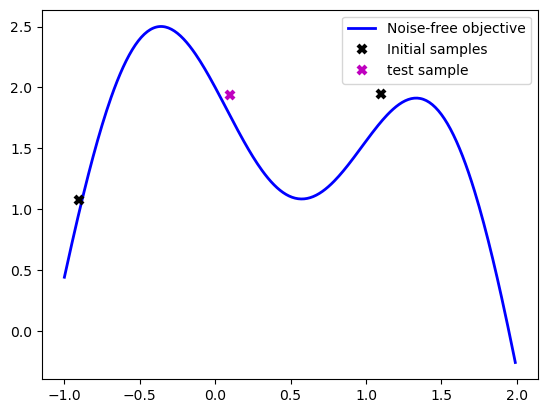

In [42]:
bounds = np.array([[-1.0, 2.0]])
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

X_train = np.array([-0.9, 1.1], ndmin=2).T
y_train = test_fun(X_train)
# Noise-free objective function values at X 
Y = test_fun(X,noise=0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'b', lw=2, label='Noise-free objective')
plt.plot(X_train, y_train, 'kx', mew=3, label='Initial samples')
plt.plot(np.array(0.1), test_fun(np.array([0.1], ndmin=2)), 'mx', mew=3, label='test sample')
plt.legend()

In [43]:
from GPclass import GaussianProcess
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from scipy.linalg import cholesky, cho_solve, solve_triangular
noise = 0.1
m52 = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
gpr2 = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
gpr3 = GaussianProcessRegressor(kernel=m52, alpha=noise**2)
X_train = np.array([-0.9, 1.1], ndmin=2).T
X_train2 = np.array([-1.9, -1.4, -0.9, -0.4, 0.1, 0.6, 1.1, 1.6], ndmin=2).T
x_test = np.array([0.1],ndmin=2).T
x_test2 = np.arange(-0.35,-0.05,0.05).reshape(-1, 1)
y_train = test_fun(X_train)
y_train2 = test_fun(X_train2)
gpr.fit(X_train,y_train)
gpr2.fit(X_train2,y_train2)
print(x_test.shape, x_test2.shape)
K = gpr.kernel_(X_train)
L = 2
print("y_train",y_train)
print("gpr3",gpr3.predict(X_train, return_cov=True), "kern", gpr3.kernel(X_train))
print("K",K, "alpha",gpr.alpha, "L_",gpr.L_)
K_trans = gpr.kernel_(x_test,gpr.X_train_)
y_mean = K_trans @ gpr.alpha_
print("alpha_",gpr.alpha_,"X_train",gpr.X_train_, "kernel", gpr.kernel_)
print("K_trans", K_trans, "y_mean",y_mean)
print(gpr.predict(x_test,return_cov=True))
print("gpr2 pred", max(gpr2.predict(x_test2)), "m_opt", max(y_train2))

(1, 1) (6, 1)
y_train [[1.21032801]
 [1.79609933]]
gpr3 (array([0., 0.]), array([[1.        , 0.13866022],
       [0.13866022, 1.        ]])) kern [[1.         0.13866022]
 [0.13866022 1.        ]]
K [[1.         0.85640298]
 [0.85640298 1.        ]] alpha 0.010000000000000002 L_ [[1.00498756 0.        ]
 [0.85215282 0.53276222]]
alpha_ [[-1.10143788]
 [ 2.7122515 ]] X_train [[-0.9]
 [ 1.1]] kernel Matern(length_scale=4.44, nu=2.5)
K_trans [[0.95972656 0.95972656]] y_mean [[1.54594062]]
(array([1.54594062]), array([[0.01299443]]))
gpr2 pred 2.514677925738586 m_opt [2.51918152]
